In [1]:
from pvml import naivebayes as nb
import numpy as np
from collections import Counter as counter
import glob
import pandas as pd

In [2]:
#!/usr/bin/env python

"""Porter Stemming Algorithm
This is the Porter stemming algorithm, ported to Python from the
version coded up in ANSI C by the author. It may be be regarded
as canonical, in that it follows the algorithm presented in

Porter, 1980, An algorithm for suffix stripping, Program, Vol. 14,
no. 3, pp 130-137,

only differing from it at the points maked --DEPARTURE-- below.

See also http://www.tartarus.org/~martin/PorterStemmer

The algorithm as described in the paper could be exactly replicated
by adjusting the points of DEPARTURE, but this is barely necessary,
because (a) the points of DEPARTURE are definitely improvements, and
(b) no encoding of the Porter stemmer I have seen is anything like
as exact as this version, even with the points of DEPARTURE!

Vivake Gupta (v@nano.com)

Release 1: January 2001

Further adjustments by Santiago Bruno (bananabruno@gmail.com)
to allow word input not restricted to one word per line, leading
to:

release 2: July 2008
"""

import sys

class PorterStemmer:

    def __init__(self):
        """The main part of the stemming algorithm starts here.
        b is a buffer holding a word to be stemmed. The letters are in b[k0],
        b[k0+1] ... ending at b[k]. In fact k0 = 0 in this demo program. k is
        readjusted downwards as the stemming progresses. Zero termination is
        not in fact used in the algorithm.

        Note that only lower case sequences are stemmed. Forcing to lower case
        should be done before stem(...) is called.
        """

        self.b = ""  # buffer for word to be stemmed
        self.k = 0
        self.k0 = 0
        self.j = 0   # j is a general offset into the string

    def cons(self, i):
        """cons(i) is TRUE <=> b[i] is a consonant."""
        if self.b[i] == 'a' or self.b[i] == 'e' or self.b[i] == 'i' or self.b[i] == 'o' or self.b[i] == 'u':
            return 0
        if self.b[i] == 'y':
            if i == self.k0:
                return 1
            else:
                return (not self.cons(i - 1))
        return 1

    def m(self):
        """m() measures the number of consonant sequences between k0 and j.
        if c is a consonant sequence and v a vowel sequence, and <..>
        indicates arbitrary presence,

           <c><v>       gives 0
           <c>vc<v>     gives 1
           <c>vcvc<v>   gives 2
           <c>vcvcvc<v> gives 3
           ....
        """
        n = 0
        i = self.k0
        while 1:
            if i > self.j:
                return n
            if not self.cons(i):
                break
            i = i + 1
        i = i + 1
        while 1:
            while 1:
                if i > self.j:
                    return n
                if self.cons(i):
                    break
                i = i + 1
            i = i + 1
            n = n + 1
            while 1:
                if i > self.j:
                    return n
                if not self.cons(i):
                    break
                i = i + 1
            i = i + 1

    def vowelinstem(self):
        """vowelinstem() is TRUE <=> k0,...j contains a vowel"""
        for i in range(self.k0, self.j + 1):
            if not self.cons(i):
                return 1
        return 0

    def doublec(self, j):
        """doublec(j) is TRUE <=> j,(j-1) contain a double consonant."""
        if j < (self.k0 + 1):
            return 0
        if (self.b[j] != self.b[j-1]):
            return 0
        return self.cons(j)

    def cvc(self, i):
        """cvc(i) is TRUE <=> i-2,i-1,i has the form consonant - vowel - consonant
        and also if the second c is not w,x or y. this is used when trying to
        restore an e at the end of a short  e.g.

           cav(e), lov(e), hop(e), crim(e), but
           snow, box, tray.
        """
        if i < (self.k0 + 2) or not self.cons(i) or self.cons(i-1) or not self.cons(i-2):
            return 0
        ch = self.b[i]
        if ch == 'w' or ch == 'x' or ch == 'y':
            return 0
        return 1

    def ends(self, s):
        """ends(s) is TRUE <=> k0,...k ends with the string s."""
        length = len(s)
        if s[length - 1] != self.b[self.k]: # tiny speed-up
            return 0
        if length > (self.k - self.k0 + 1):
            return 0
        if self.b[self.k-length+1:self.k+1] != s:
            return 0
        self.j = self.k - length
        return 1

    def setto(self, s):
        """setto(s) sets (j+1),...k to the characters in the string s, readjusting k."""
        length = len(s)
        self.b = self.b[:self.j+1] + s + self.b[self.j+length+1:]
        self.k = self.j + length

    def r(self, s):
        """r(s) is used further down."""
        if self.m() > 0:
            self.setto(s)

    def step1ab(self):
        """step1ab() gets rid of plurals and -ed or -ing. e.g.

           caresses  ->  caress
           ponies    ->  poni
           ties      ->  ti
           caress    ->  caress
           cats      ->  cat

           feed      ->  feed
           agreed    ->  agree
           disabled  ->  disable

           matting   ->  mat
           mating    ->  mate
           meeting   ->  meet
           milling   ->  mill
           messing   ->  mess

           meetings  ->  meet
        """
        if self.b[self.k] == 's':
            if self.ends("sses"):
                self.k = self.k - 2
            elif self.ends("ies"):
                self.setto("i")
            elif self.b[self.k - 1] != 's':
                self.k = self.k - 1
        if self.ends("eed"):
            if self.m() > 0:
                self.k = self.k - 1
        elif (self.ends("ed") or self.ends("ing")) and self.vowelinstem():
            self.k = self.j
            if self.ends("at"):   self.setto("ate")
            elif self.ends("bl"): self.setto("ble")
            elif self.ends("iz"): self.setto("ize")
            elif self.doublec(self.k):
                self.k = self.k - 1
                ch = self.b[self.k]
                if ch == 'l' or ch == 's' or ch == 'z':
                    self.k = self.k + 1
            elif (self.m() == 1 and self.cvc(self.k)):
                self.setto("e")

    def step1c(self):
        """step1c() turns terminal y to i when there is another vowel in the stem."""
        if (self.ends("y") and self.vowelinstem()):
            self.b = self.b[:self.k] + 'i' + self.b[self.k+1:]

    def step2(self):
        """step2() maps double suffices to single ones.
        so -ization ( = -ize plus -ation) maps to -ize etc. note that the
        string before the suffix must give m() > 0.
        """
        if self.b[self.k - 1] == 'a':
            if self.ends("ational"):   self.r("ate")
            elif self.ends("tional"):  self.r("tion")
        elif self.b[self.k - 1] == 'c':
            if self.ends("enci"):      self.r("ence")
            elif self.ends("anci"):    self.r("ance")
        elif self.b[self.k - 1] == 'e':
            if self.ends("izer"):      self.r("ize")
        elif self.b[self.k - 1] == 'l':
            if self.ends("bli"):       self.r("ble") # --DEPARTURE--
            # To match the published algorithm, replace this phrase with
            #   if self.ends("abli"):      self.r("able")
            elif self.ends("alli"):    self.r("al")
            elif self.ends("entli"):   self.r("ent")
            elif self.ends("eli"):     self.r("e")
            elif self.ends("ousli"):   self.r("ous")
        elif self.b[self.k - 1] == 'o':
            if self.ends("ization"):   self.r("ize")
            elif self.ends("ation"):   self.r("ate")
            elif self.ends("ator"):    self.r("ate")
        elif self.b[self.k - 1] == 's':
            if self.ends("alism"):     self.r("al")
            elif self.ends("iveness"): self.r("ive")
            elif self.ends("fulness"): self.r("ful")
            elif self.ends("ousness"): self.r("ous")
        elif self.b[self.k - 1] == 't':
            if self.ends("aliti"):     self.r("al")
            elif self.ends("iviti"):   self.r("ive")
            elif self.ends("biliti"):  self.r("ble")
        elif self.b[self.k - 1] == 'g': # --DEPARTURE--
            if self.ends("logi"):      self.r("log")
        # To match the published algorithm, delete this phrase

    def step3(self):
        """step3() dels with -ic-, -full, -ness etc. similar strategy to step2."""
        if self.b[self.k] == 'e':
            if self.ends("icate"):     self.r("ic")
            elif self.ends("ative"):   self.r("")
            elif self.ends("alize"):   self.r("al")
        elif self.b[self.k] == 'i':
            if self.ends("iciti"):     self.r("ic")
        elif self.b[self.k] == 'l':
            if self.ends("ical"):      self.r("ic")
            elif self.ends("ful"):     self.r("")
        elif self.b[self.k] == 's':
            if self.ends("ness"):      self.r("")

    def step4(self):
        """step4() takes off -ant, -ence etc., in context <c>vcvc<v>."""
        if self.b[self.k - 1] == 'a':
            if self.ends("al"): pass
            else: return
        elif self.b[self.k - 1] == 'c':
            if self.ends("ance"): pass
            elif self.ends("ence"): pass
            else: return
        elif self.b[self.k - 1] == 'e':
            if self.ends("er"): pass
            else: return
        elif self.b[self.k - 1] == 'i':
            if self.ends("ic"): pass
            else: return
        elif self.b[self.k - 1] == 'l':
            if self.ends("able"): pass
            elif self.ends("ible"): pass
            else: return
        elif self.b[self.k - 1] == 'n':
            if self.ends("ant"): pass
            elif self.ends("ement"): pass
            elif self.ends("ment"): pass
            elif self.ends("ent"): pass
            else: return
        elif self.b[self.k - 1] == 'o':
            if self.ends("ion") and (self.b[self.j] == 's' or self.b[self.j] == 't'): pass
            elif self.ends("ou"): pass
            # takes care of -ous
            else: return
        elif self.b[self.k - 1] == 's':
            if self.ends("ism"): pass
            else: return
        elif self.b[self.k - 1] == 't':
            if self.ends("ate"): pass
            elif self.ends("iti"): pass
            else: return
        elif self.b[self.k - 1] == 'u':
            if self.ends("ous"): pass
            else: return
        elif self.b[self.k - 1] == 'v':
            if self.ends("ive"): pass
            else: return
        elif self.b[self.k - 1] == 'z':
            if self.ends("ize"): pass
            else: return
        else:
            return
        if self.m() > 1:
            self.k = self.j

    def step5(self):
        """step5() removes a final -e if m() > 1, and changes -ll to -l if
        m() > 1.
        """
        self.j = self.k
        if self.b[self.k] == 'e':
            a = self.m()
            if a > 1 or (a == 1 and not self.cvc(self.k-1)):
                self.k = self.k - 1
        if self.b[self.k] == 'l' and self.doublec(self.k) and self.m() > 1:
            self.k = self.k -1

    def stem(self, p, i, j):
        """In stem(p,i,j), p is a char pointer, and the string to be stemmed
        is from p[i] to p[j] inclusive. Typically i is zero and j is the
        offset to the last character of a string, (p[j+1] == '\0'). The
        stemmer adjusts the characters p[i] ... p[j] and returns the new
        end-point of the string, k. Stemming never increases word length, so
        i <= k <= j. To turn the stemmer into a module, declare 'stem' as
        extern, and delete the remainder of this file.
        """
        # copy the parameters into statics
        self.b = p
        self.k = j
        self.k0 = i
        if self.k <= self.k0 + 1:
            return self.b # --DEPARTURE--

        # With this line, strings of length 1 or 2 don't go through the
        # stemming process, although no mention is made of this in the
        # published algorithm. Remove the line to match the published
        # algorithm.

        self.step1ab()
        self.step1c()
        self.step2()
        self.step3()
        self.step4()
        self.step5()
        return self.b[self.k0:self.k+1]


_stemmer = PorterStemmer()


def stem(w):
    return _stemmer.stem(w, 0, len(w) - 1)

In [3]:
train_path="aclImdb/train"
n=5000
st=True
ic=True

In [4]:
def read_file(flist, ignore_common=False, stemming=False):
    k=[]
    p="!\"#$&'()*+,-./:;<=>?@[\\]^_{|}~`1234567890"
    table=str.maketrans(p, " " * len(p))
    if ignore_common==False and stemming==False:
        for f in flist:
            f=open(f, "r")
            for line in f:
                line=line.translate(table)
                for word in line.split():
                    if len(word)>2: 
                        k.append(word.lower())
        f.close()
    elif ignore_common==True and stemming==False:
        f=open("aclImdb/stopwords.txt", "r")
        common=[]
        for w in f.read().split():
            common.append(w)
        f.close()
        #print(common)
        for f in flist:
            f=open(f, "r")
            for line in f:
                line=line.translate(table)
                for word in line.split():
                    if len(word)>2 and word.lower() not in common:
                        k.append(word.lower())
        f.close()
    elif stemming==True and ignore_common==False:
        for f in flist:
            f=open(f, "r")
            for line in f:
                line=line.translate(table)
                for word in line.split():
                    word=stem(word.lower())
                    if len(word)>2: 
                        k.append(word)
        f.close()
    
    elif stemming==True and ignore_common==True:
        f=open("aclImdb/stopwords.txt", "r")
        common=[]
        for w in f.read().split():
            common.append(stem(w.lower()))
        f.close()
        #print(common)
        for f in flist:
            f=open(f, "r")
            for line in f:
                line=line.translate(table)
                for word in line.split():
                    word=stem(word.lower())
                    if len(word)>2 and word not in common: 
                        k.append(word)
        f.close()
   
    return k

def file_list(path, pn): #pn stands for positive/negative
    files = [f for f in glob.glob(path + "/" + pn + "**/*.txt", recursive=True)]
    return files

def build_dict(path, n, save, ignore_common=False, stemming=False):
    fl=file_list(path, "")
    words=read_file(fl, ignore_common, stemming)
    dic=sorted(counter(words).most_common(n))
    if save==False:
        return dic
    else:
        f=open("vocabulary_" + str(n)+".txt", "w")
        for w in [word for word, word_count in dic]:
            f.write(str(w)+"\n")
        f.close()
        


build_dict(train_path,n,True, stemming=st, ignore_common=ic)

In [5]:
def build_bow(path,save, fname, size, stemming=False):
    f=open("vocabulary_" + str(size) + ".txt", "r")
    nfl=file_list(path, "neg")
    pfl=file_list(path, "pos")
    n=0
    doc=0
    voc={}
    dic=[]
    for w in f.read().split():
        voc[w]=n
        dic.append(w)
        n+=1
    f.close()
    p="!\"#$&'()*+,-./:;<=>?@[\\]^_{|}~"
    table=str.maketrans(p, " " * len(p))
    matrix=np.zeros((len(nfl)+len(pfl), n+1))
    if stemming==False:
        #Read Negative Reviews
        for f in nfl:
            f=open(f, "r")
            #print(f)
            for line in f:
                line=line.translate(table)
                for w in line.split():
                    w=w.lower()
                    if w in dic:
                        matrix[doc][voc[w]]+=1
            f.close()
            matrix[doc][n]=0
            doc+=1
        #Read Positive Reviews
        for f in pfl:
            f=open(f, "r")
            for line in f:
                line=line.translate(table)
                for w in line.split():
                    w=w.lower()
                    if w in dic:
                        matrix[doc][voc[w]]+=1
            f.close()
            matrix[doc][n]=1
            doc+=1
    else:
        #Read Negative Reviews
        for f in nfl:
            f=open(f, "r")
            for line in f:
                line=line.translate(table)
                for w in line.split():
                    w=stem(w.lower())
                    if w in dic:
                        matrix[doc][voc[w]]+=1
            f.close()
            matrix[doc][n]=0
            doc+=1
        #Read Positive Reviews
        for f in pfl:
            f=open(f, "r")
            for line in f:
                line=line.translate(table)
                for w in line.split():
                    w=stem(w.lower())
                    if w in dic:
                        matrix[doc][voc[w]]+=1
            f.close()
            matrix[doc][n]=1
            doc+=1

    if save==False:
        return matrix
    else:
        np.savetxt(fname+".gz", matrix.astype(np.int32))

In [6]:
val_path="aclImdb/validation"
test_path="aclImdb/test"
train_name= "train_" + str(n)
test_name="test_" + str(n)
val_name="val_" + str(n)

In [7]:
#m_test=build_bow(train_path, False, train_name, stemming=st, size=n)
#print(m_test.shape)
    
build_bow(train_path, True, train_name, stemming=st, size=n)
build_bow(test_path, True, test_name , stemming=st, size=n)
build_bow(val_path, True, val_name, stemming=st, size=n)

In [8]:
#train_data=np.loadtxt(train_name+".gz", dtype=np.int32)
#val_data=np.loadtxt(val_name + ".gz", dtype=np.int32)
#test_data=np.loadtxt(test_name + ".gz", dtype=np.int32)

train_data=pd.read_csv(train_name+".gz", compression="gzip", dtype=np.int32, sep=" ", header=None).to_numpy()
val_data=pd.read_csv(val_name + ".gz", compression="gzip", dtype=np.int32, sep=" ", header=None).to_numpy()
test_data=pd.read_csv(test_name + ".gz", compression="gzip", dtype=np.int32, sep=" ", header=None).to_numpy()

In [9]:
X=train_data[:,:-1]
Y=train_data[:,-1]

w,b=nb.multinomial_naive_bayes_train(X,Y)
labels,scores=nb.multinomial_naive_bayes_inference(X,w,b)

def most_influential(w,n):
    pos=(w[:,1])
    neg=(w[:,0])
    diff=abs(pos-neg)
    #return neg.argsort()[:n], pos.argsort()[:n]
    return diff.argsort()[-n:]#, neg.argsort()[:n], pos.argsort()[-n:]

mi=20 #most influential words number
diff= most_influential(w,mi)

#Recreate Vocabulary
f=open("vocabulary_" +str(n)+".txt", "r")
vo=[]

for l in f.read().split():
        vo.append(l)

f.close()

for i in range(mi):
    if i==0:
        print("Most Polarizing Words, Best, Worst")
    print(vo[diff[mi-1-i]])#, vo[pos[mi-1-i]], vo[neg[mi-1-i]])


accuracy=(labels==Y).mean()*100
print("Training Accuracy: ", accuracy)

X=val_data[:,:-1]
Y=val_data[:,-1]
labels,scores=nb.multinomial_naive_bayes_inference(X,w,b)
accuracy=(labels==Y).mean()*100
print("Validation Accuracy: ", accuracy)

X=test_data[:,:-1]
Y=test_data[:,-1]
labels,scores=nb.multinomial_naive_bayes_inference(X,w,b)
accuracy=(labels==Y).mean()*100
print("Test Accuracy: ", accuracy)

#Compute Wrong Classifications
w_n=5 #<- Number of Wrong Classifications to Show
wrong=np.asarray((labels!=Y))

w_scores=[]
for i in range(len(wrong)):
    if wrong[i]==True:
        w_scores.append(abs(scores[i,0]-scores[i,1]))#/abs(scores[i,:].mean()))

w_scores=np.array(w_scores)
print(len(w_scores))
w_index=w_scores.argsort()#[-w_n:]

for i in range(w_n):
    print(file_list(test_path, "")[w_index[w_n-1-i]])

'''
np.savetxt("bayes_"+ str(n)+ "_"+ "_weights.txt", w)
f=open("bayes_"+ str(n)+ "_bias.txt", "w")
f.write(str(b))
f.close()
'''

Most Polarizing Words, Best, Worst
antwon
boll
gunga
goldsworthi
gypo
yokai
din
thunderbird
edi
gundam
beowulf
wayan
seagal
felix
dreck
capot
fido
gamera
vanc
hayworth
Training Accuracy:  85.408
Validation Accuracy:  82.872
Test Accuracy:  82.26400000000001
2217
aclImdb/test/neg/3138_1.txt
aclImdb/test/neg/11624_4.txt
aclImdb/test/neg/3282_1.txt
aclImdb/test/neg/10056_1.txt
aclImdb/test/neg/7206_3.txt


'\nnp.savetxt("bayes_"+ str(n)+ "_"+ "_weights.txt", w)\nf=open("bayes_"+ str(n)+ "_bias.txt", "w")\nf.write(str(b))\nf.close()\n'

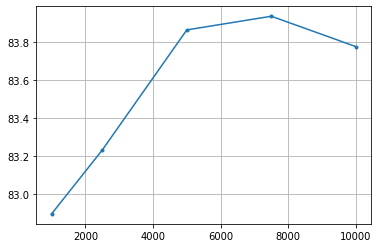

In [13]:
import matplotlib.pyplot as plt

acc=np.loadtxt("test_accuracy.txt", unpack=True)
#print(acc)
plt.plot(acc[0], acc[1], marker=".")
plt.grid()
plt.show()

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

final_model = SGDClassifier(learning_rate="invscaling", eta0=1., alpha=0)
final_model.fit(X, Y)
print ("Final Accuracy: %s" 
       % accuracy_score(Y, final_model.predict(X)))

Final Accuracy: 0.9008
